In [4]:
import numpy as np
import scipy as sp
import sklearn as skl
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from skimage.transform import resize
import matplotlib as mpl
import matplotlib.pyplot as plt
import zipfile as zf
import pandas as pd
# import cv2
# import PIL as pil

In [5]:
archive = zf.ZipFile('data/archive.zip')

metafile  = archive.open('Meta.csv')
testfile  = archive.open('Test.csv')
trainfile = archive.open('Train.csv')

meta  = pd.read_csv(metafile)
test  = pd.read_csv(testfile)
train = pd.read_csv(trainfile)

train_images = [ mpl.image.imread(archive.open(imfile)) for imfile in train.Path]
train_labels = np.array(train.ClassId)

test_images  = [ mpl.image.imread(archive.open(imfile)) for imfile in test.Path]
test_labels  = np.array(test.ClassId)

In [82]:
def only_ROI(img,roi):
    return img[ roi[1]:roi[3], roi[0]:roi[2] ]

train_data = [only_ROI(img,roi) for img,roi    \
       in zip(train_images, train[['Roi.X1','Roi.Y1','Roi.X2', 'Roi.Y2']].to_numpy())]
test_data  = [only_ROI(img,roi) for img,roi    \
       in zip(test_images,   test[['Roi.X1','Roi.Y1','Roi.X2', 'Roi.Y2']].to_numpy())]

In [94]:
# T = test[['Roi.X1','Roi.Y1','Roi.X2', 'Roi.Y2']].to_numpy()
# T = test_data
for i,img in enumerate(test_data):
    tst = np.all(np.isfinite(img))
    if not tst:
        print(i)
        

test_tmp = [resize(img,(15,15,3)) for img in test_data]

In [97]:
def adjust_range(img):
    ''' Make sure all pixels are in range [0,255]'''
    initial_range = np.ptp(img)
    img /= initial_range
    img -= np.min(img)
    
    return img


test_tmp2 = [adjust_range(img) for img in test_tmp]


In [100]:
test_tmp3 = np.array([flatten(img) for img in test_tmp2])


In [101]:
np.all(np.isfinite(np.array(test_tmp3)))

True

In [102]:
# NOTE: THESE FUNCTIONS CURRENTLY ONLY WORK ON ONE IMAGE AT A TIME
# (because trying to generalize was introducing sneaky bugs)




def flatten(img, rgb2gray=False):
    # Convert image to grayscale first
    if rgb2gray:
        img = np.mean(img,axis=-1)
        
    img = np.reshape(img, (-1))
    
    return img


def process(img, resize_to=None, flat=True, rgb2gray=False):
    # Resize image to desired size
    if resize_to is not None:
        img = resize(img, resize_to) 
        
    # Rescale image to have all pixel values on [0,1]
    img = adjust_range(img)
    
    if flat:
        img = flatten(img, rgb2gray=rgb2gray)
    return img


train_data = [only_ROI(img,roi) for img,roi    \
       in zip(train_images, train[['Roi.X1','Roi.Y1','Roi.X2', 'Roi.Y2']].to_numpy())]

shapes = np.array([im.shape for im in train_data])
resize_to = np.min(shapes,axis=0)
train_data = np.array([process(img, resize_to=resize_to, flat=True) for img in train_data])
test_data  = np.array([process(img, resize_to=resize_to, flat=True) for img in test_data]) 

# Standardize each feature across all samples
train_data -= np.mean(train_data,axis=0) / np.std(train_data,axis=0)
test_data -= np.mean(test_data,axis=0) / np.std(test_data,axis=0)

0.086180516
0.09570788
0.097337306
0.090260394
0.09397617
0.08910182
0.08840079
0.093912825
0.09721835
0.08573313
0.09002552
0.095209986
0.08608193
0.08150637
0.080907844
0.09235379
0.051830072
0.05307189
0.05647059
0.06203922
0.05704575
0.060200438
0.057254814
0.058534704
0.056665443
0.06052403
0.060810313
0.061078377
0.05609192
0.06289579
0.06352805
0.0591347
0.05899563
0.07947713
0.0947974
0.08363413
0.07669754
0.08257325
0.07538818
0.07480402
0.076607004
0.08831373
0.09464054
0.08669281
0.0908584
0.09019607
0.08496733
0.09346408
0.089411706
0.094117455
0.09019413
0.09170544
0.09613837
0.09463682
0.092607066
0.09951289
0.0970099
0.09512209
0.09612165
0.09159769
0.0974052
0.08973523
0.09487234
0.08846316
0.0947172
0.089841776
0.09797745
0.09059232
0.09327698
0.09208767
0.08846045
0.0852741
0.08074973
0.07794827
0.07827326
0.078306966
0.081045315
0.08004
0.07788789
0.07807671
0.07989928
0.07922385
0.084617384
0.079314545
0.08078867
0.08190049
0.07812631
0.078594394
0.077432886
0.07891

In [104]:
np.all(np.isfinite(test_data))

True

In [146]:
pca = skl.decomposition.PCA(n_components=0.95)
pca_train = pca.fit_transform(train_data)

In [147]:
dtree = DecisionTreeClassifier()

dtree.fit(pca_train, train_labels)


pca_test = pca.transform(test_data)

# predict labels using the trained classifier
predicted_test_labels = dtree.predict(pca_test)

In [148]:
cm = confusion_matrix(test_labels, predicted_test_labels)

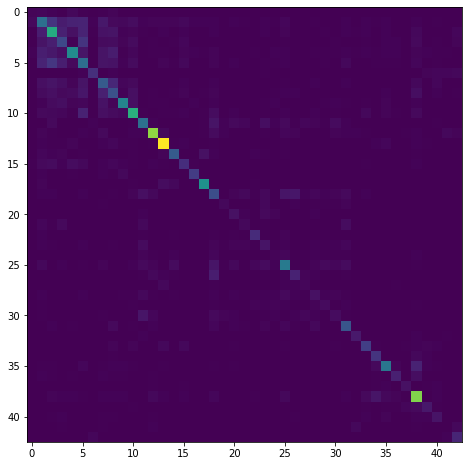

In [149]:
plt.figure(figsize=(8,8))
plt.imshow(cm)

In [150]:
accuracy_score(test_labels, predicted_test_labels) 

0.5019002375296913

<BarContainer object of 78 artists>

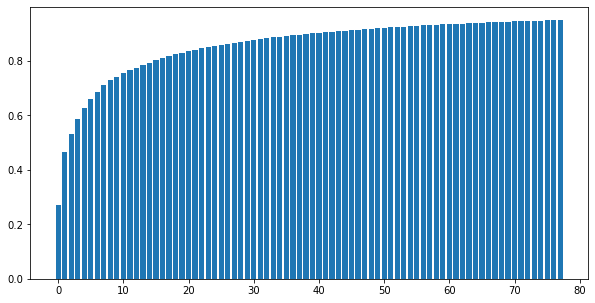

In [151]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5), facecolor='white')
plt.bar(range(len(exp_var_cumul)), exp_var_cumul)

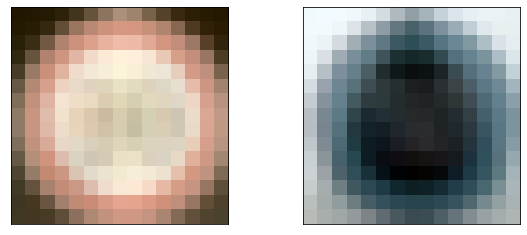

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(adjust_range(pca.components_[i].reshape(15, 15,3)))

# plt.imshow(adjust_range(np.reshape(pca.components_[i],(15,15,3))))